In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

K.set_image_data_format('channels_last')


2021-07-22 23:14:04.971619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
PATH = os.path.dirname(os.path.realpath(''))

LABELS_PATH = PATH + '/PatrykB/datasets/labels'
IMAGES_PATH = PATH + '/PatrykB/datasets/images'

In [3]:
def get_paths_and_gts(partition_split_file):
    paths_and_gts = []
    
    with open(partition_split_file) as f:
        for line in f:
            if not line or line.startswith('#'):
                continue
            
            line_split = line.strip().split(' ')
            
            directory_split = line_split[0].split('-')

            image_location = f'{IMAGES_PATH}/{directory_split[0]}/{directory_split[0]}-{directory_split[1]}/{line_split[0]}.png'
            
            gt_text = ' '.join(line_split[8:])
                       
            paths_and_gts.append([image_location, gt_text])
    
    return paths_and_gts

def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    img = cv2.imread(path)

    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(np.float32)
    img /= 255
    return img

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def numbered_array_to_text(numbered_array):
    numbered_array = numbered_array[numbered_array != -1]
    return "".join(letters[i] for i in numbered_array)

In [4]:
letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
           '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
           'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

num_classes = len(letters) + 1
print(num_classes)

80


In [5]:
files = get_paths_and_gts(f'{LABELS_PATH}/words.txt')
len(files)

115318

In [6]:
train, test = train_test_split(files, test_size=0.1)
len(train), len(test)

(103786, 11532)

In [7]:
class TextImageGenerator:
    
    def __init__(self, data,
                 img_w,
                 img_h, 
                 batch_size, 
                 i_len,
                 max_text_len):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.samples = data
        self.n = len(self.samples)
        self.i_len = i_len
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = preprocess(img_filepath, self.img_w, self.img_h)
            self.imgs[i, :, :] = img
            self.texts.append(text)
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * self.i_len
            label_length = np.zeros((self.batch_size, 1))
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i, :len(text)] = text_to_labels(text)
                label_length[i] = len(text)
                
            inputs = [X_data, Y_data, input_length, label_length]
            outputs = np.zeros([self.batch_size])
            yield (inputs, outputs)

In [8]:
batch_size = 64
input_length = 30
max_text_len = 60
img_w = 128
img_h = 64

In [9]:
train_data = TextImageGenerator(train, img_w, img_h, batch_size, input_length, max_text_len)
train_data.build_data()
train_data.imgs.shape

(103786, 64, 128)

In [10]:
validation_data = TextImageGenerator(test, img_w, img_h, batch_size, input_length, max_text_len)
validation_data.build_data()
validation_data.imgs.shape

(11532, 64, 128)

In [11]:
input_data = layers.Input(name='the_input', shape=(128,64,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer (VGG)
iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal',
                           activation='relu')(input_data)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(iam_layers)  # (None,64, 32, 64)
iam_layers = layers.Dropout(0.2)(iam_layers)

iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal',
                           activation='relu')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(iam_layers)
iam_layers = layers.Dropout(0.2)(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal',
                           kernel_regularizer=regularizers.l2(0.0001), activation='relu')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal',
                           kernel_regularizer=regularizers.l2(0.0001), activation='relu')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(iam_layers)  # (None, 32, 8, 256)
iam_layers = layers.Dropout(0.2)(iam_layers)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal',
                           activation='relu')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6', activation='relu')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(iam_layers)
iam_layers = layers.Dropout(0.2)(iam_layers)

iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7',
                           kernel_regularizer=regularizers.l2(0.0001), activation='relu')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Dropout(0.2)(iam_layers)

iam_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(iam_layers)
iam_layers = layers.Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

iam_outputs = layers.Dense(80, kernel_initializer='he_normal', name='dense2', activation='softmax')(iam_layers)

labels = layers.Input(name='the_labels', shape=[60], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)



loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()

2021-07-22 23:16:23.718087: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-22 23:16:23.718713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-22 23:16:23.827347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-22 23:16:23.828090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1070 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 19 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-07-22 23:16:23.828139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-07-22 23:16:23.882779: I tensorflow/stream_executor/platform

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 64)  640         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 64, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

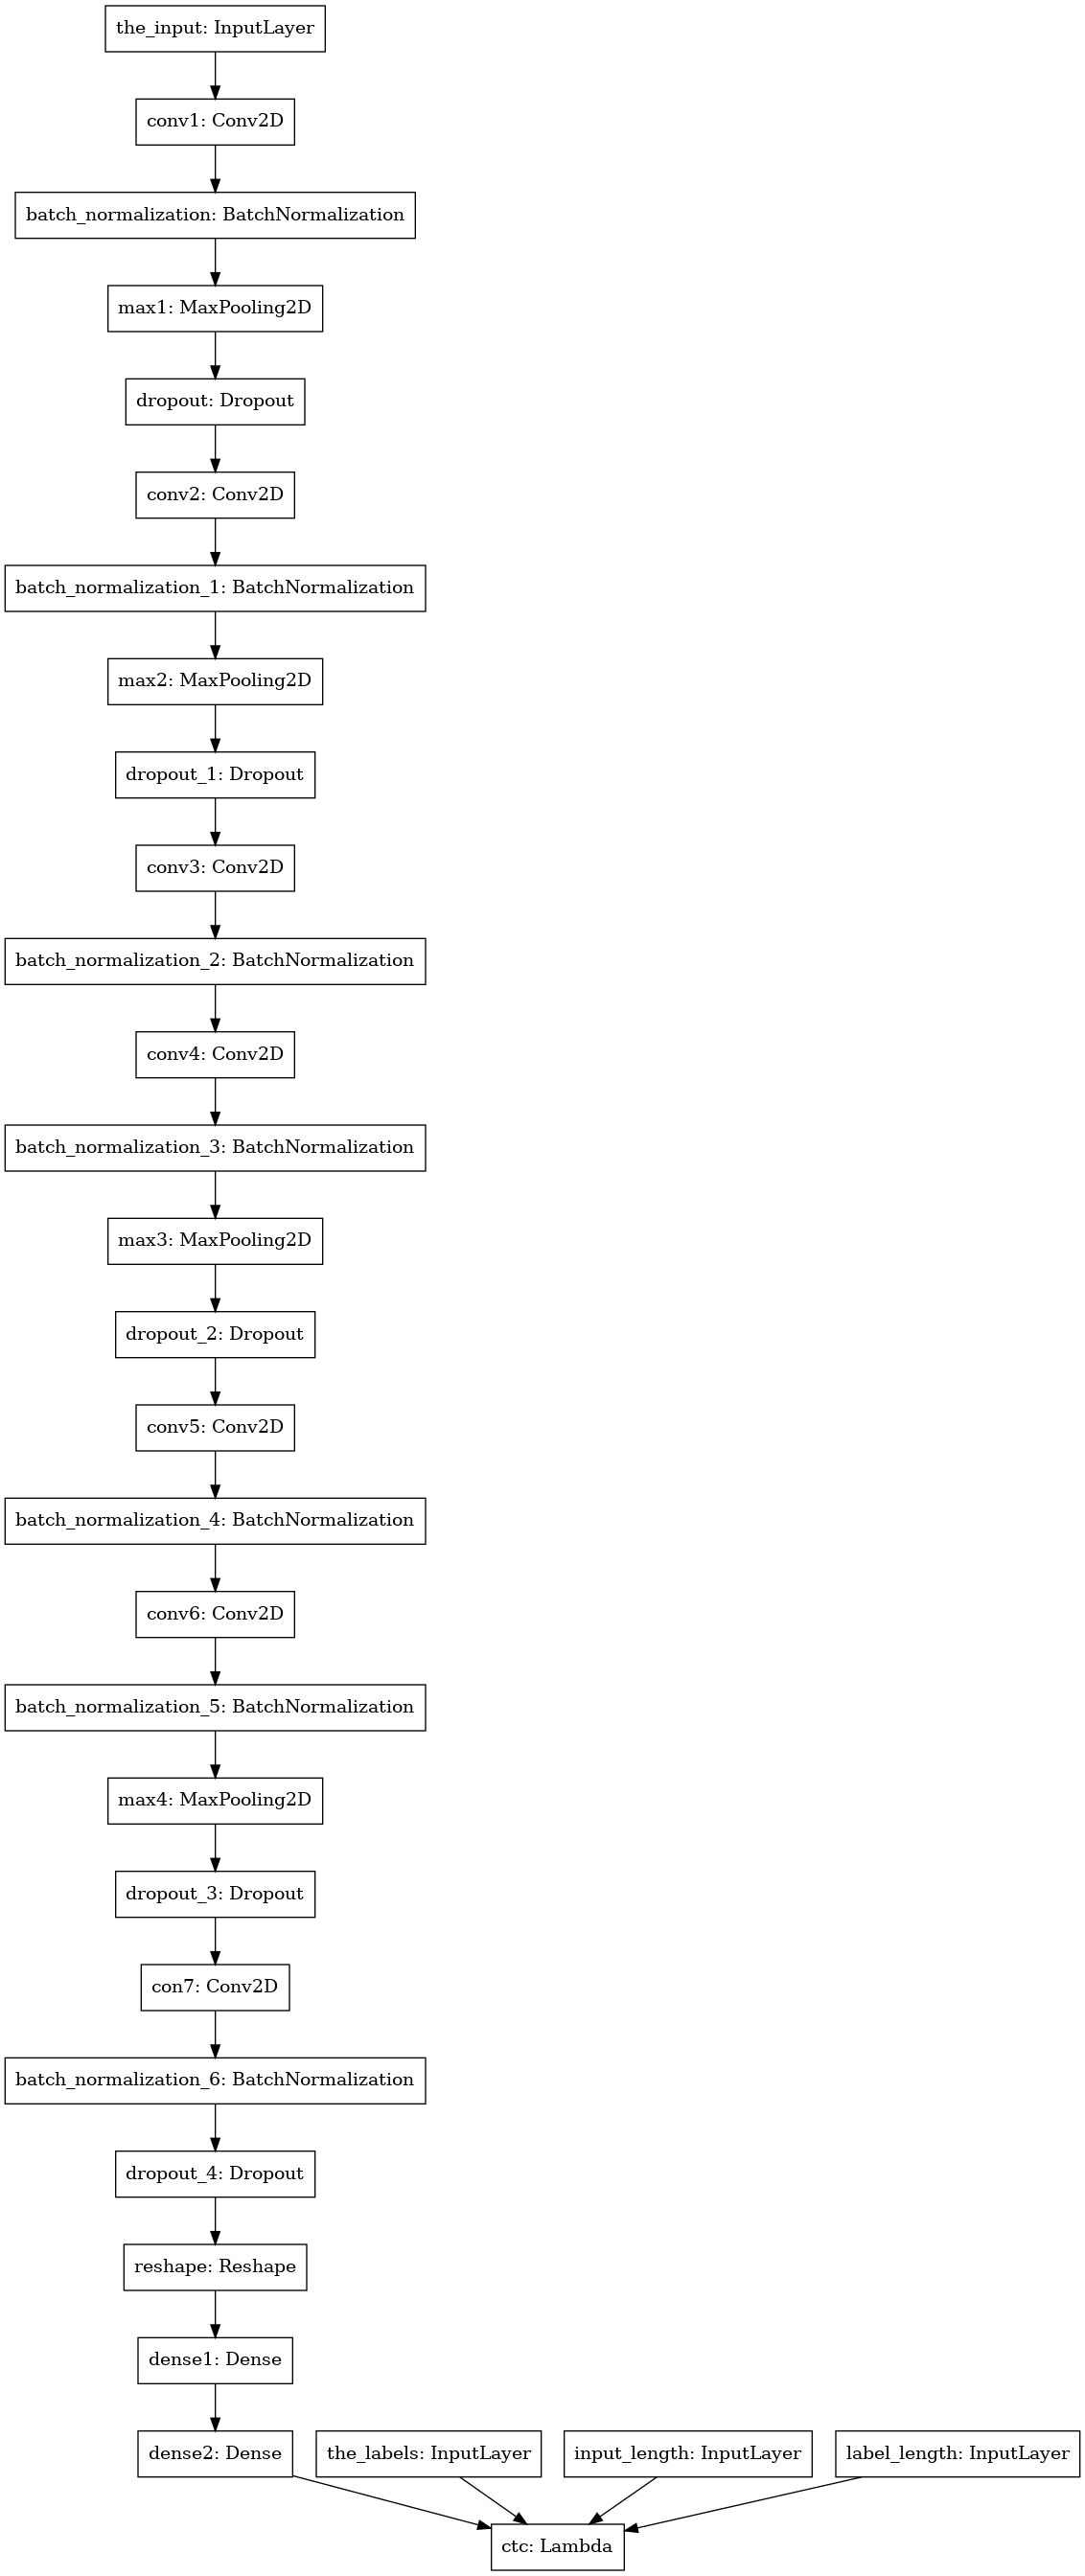

In [12]:
plot_model(model, to_file='CONV_model.png')

In [12]:
optimizer = SGD(lr=0.001, momentum=0, decay=1e-5, nesterov=True)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [13]:
callbacks = [
    ModelCheckpoint('conv_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=False),
#     EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='min')
]

In [14]:
history = model.fit(train_data.next_batch(),
                                    validation_data=validation_data.next_batch(),
                                    steps_per_epoch=train_data.n/batch_size,
                                    validation_steps=validation_data.n // batch_size,
                                    callbacks=callbacks,
                                    epochs=100)


Epoch 1/100


2021-07-22 23:16:26.498324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-22 23:16:26.521743: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz
2021-07-22 23:16:27.471183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-07-22 23:16:28.007437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-07-22 23:16:29.927241: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-07-22 23:16:30.036807: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1621/1621 [==============================] - 202s 108ms/step - loss: 10.1622 - val_loss: 4.8980
Epoch 2/100
1621/1621 [==============================] - 176s 109ms/step - loss: 4.0255 - val_loss: 3.8191
Epoch 3/100
1621/1621 [==============================] - 176s 109ms/step - loss: 3.4537 - val_loss: 3.4933
Epoch 4/100
1621/1621 [==============================] - 176s 109ms/step - loss: 3.1959 - val_loss: 3.4847
Epoch 5/100
1621/1621 [==============================] - 176s 109ms/step - loss: 3.0051 - val_loss: 3.8928
Epoch 6/100
1621/1621 [==============================] - 176s 109ms/step - loss: 2.8764 - val_loss: 3.7315
Epoch 7/100
1621/1621 [==============================] - 176s 109ms/step - loss: 2.7781 - val_loss: 4.5455
Epoch 8/100
1621/1621 [==============================] - 176s 109ms/step - loss: 2.6736 - val_loss: 3.1481
Epoch 9/100
1621/1621 [==============================] - 176s 109ms/step - loss: 2.6058 - val_loss: 3.3967
Epoch 10/100
1621/1621 [========================

1621/1621 [==============================] - 175s 108ms/step - loss: 1.1751 - val_loss: 3.9687
Epoch 78/100
1621/1621 [==============================] - 174s 107ms/step - loss: 1.1626 - val_loss: 3.8587
Epoch 79/100
1621/1621 [==============================] - 175s 108ms/step - loss: 1.1471 - val_loss: 3.9162
Epoch 80/100
1621/1621 [==============================] - 174s 108ms/step - loss: 1.1485 - val_loss: 4.6260
Epoch 81/100
1621/1621 [==============================] - 175s 108ms/step - loss: 1.1544 - val_loss: 3.9649
Epoch 82/100
1621/1621 [==============================] - 174s 108ms/step - loss: 1.1424 - val_loss: 4.2681
Epoch 83/100
1621/1621 [==============================] - 174s 107ms/step - loss: 1.1225 - val_loss: 3.8892
Epoch 84/100
1621/1621 [==============================] - 174s 107ms/step - loss: 1.1211 - val_loss: 4.0137
Epoch 85/100
1621/1621 [==============================] - 175s 108ms/step - loss: 1.1213 - val_loss: 3.9507
Epoch 86/100
1621/1621 [=================

In [ ]:
model.save(filepath='conv_model.h5', overwrite=False, include_optimizer=True)

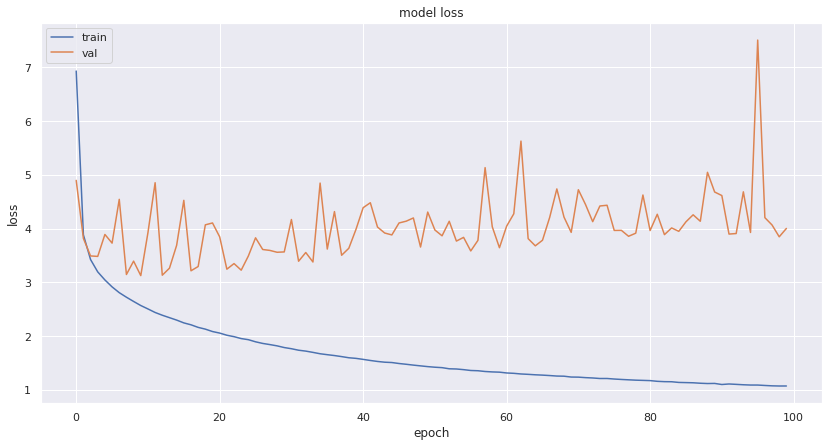

In [15]:
sns.set(rc={'figure.figsize':(14,7)})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()



In [16]:
test_images_processed = []
original_test_texts = []
for _, (test_image_path, original_test_text) in enumerate(test):
     temp_processed_image = preprocess(path=test_image_path, img_w=128, img_h=64)
     test_images_processed.append(temp_processed_image.T)
     original_test_texts.append(original_test_text)

In [ ]:
print(len(test))
print(len(test_images_processed))
print(len(original_test_texts))

In [17]:
iam_model_pred = Model(inputs=input_data, outputs=iam_outputs)

iam_model_pred.load_weights('conv_model.h5')


'the'

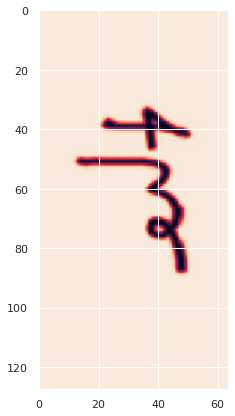

In [18]:
a = preprocess(f'{PATH}/PatrykB/Screenshot 2021-07-14 212120.png', img_w=128, img_h=64).T.reshape(1, 128, 64, 1)
#cv2.imshow('asd', a)
plt.imshow(a.reshape(128,64))

test_predictions_encoded = iam_model_pred.predict(x=a)
test_predictions_decoded = K.get_value(K.ctc_decode(test_predictions_encoded,
                                                                                  input_length = np.ones(test_predictions_encoded.shape[0])*test_predictions_encoded.shape[1],
                                                                                  greedy=True)[0][0])
numbered_array_to_text(test_predictions_decoded)